# SAE

In [1]:
from interp.all import *
from datasets import load_dataset, DatasetDict, Dataset
from huggingface_hub import hf_hub_download
from sae_lens import SAE, HookedSAETransformer
import plotly.express as px
import json
from pathlib import Path
from functools import partial
import torch as t


device = get_device()
model = load_hooked(0, sae=True).eval().to(device) # type: ignore
assert isinstance(model, HookedSAETransformer)


def load_sae(path: str) -> SAE:
    from sae_lens import SAEConfig
    from sae_lens.toolkit.pretrained_sae_loaders import read_sae_from_disk
    from sae_lens.config import DTYPE_MAP

    weight_path = hf_hub_download(SAE_REPO_ID, path + "/sae_weights.safetensors")
    cfg_path = hf_hub_download(SAE_REPO_ID, path + "/cfg.json")
    with open(cfg_path, "r") as f:
        cfg_dict = json.load(f)
    cfg_dict, state_dict = read_sae_from_disk(
        cfg_dict=cfg_dict,
        weight_path=weight_path,
        device="cpu",
        dtype=DTYPE_MAP[cfg_dict["dtype"]],
    )
    print(cfg_dict)
    sae_cfg = SAEConfig.from_dict(cfg_dict)
    sae_cfg.device = str(device)
    sae = SAE(sae_cfg)
    sae.load_state_dict(state_dict)
    sae.eval()
    return sae


sae = load_sae("gpt-0/blocks_8_mlp_out")

dataset_full = load_dataset("tommyp111/culture-puzzles-1M", split="train")
assert isinstance(dataset_full, Dataset)
dataset = load_dataset("tommyp111/culture-puzzles-1M-partitioned")
assert isinstance(dataset, DatasetDict)

dataset_full.set_format("pt")
dataset.set_format("pt")


Moving model to device:  mps
{'architecture': 'standard', 'd_in': 512, 'd_sae': 16384, 'dtype': 'float32', 'device': 'cuda', 'model_name': 'culture-gpt-0', 'hook_name': 'blocks.8.hook_mlp_out', 'hook_layer': 8, 'hook_head_index': None, 'activation_fn_str': 'relu', 'activation_fn_kwargs': {}, 'apply_b_dec_to_input': False, 'finetuning_scaling_factor': False, 'sae_lens_training_version': '3.14.0', 'prepend_bos': True, 'dataset_path': 'tommyp111/culture-puzzles-1M', 'dataset_trust_remote_code': True, 'context_size': 405, 'normalize_activations': 'none', 'l1_coefficient': 5, 'lp_norm': 1.0, 'use_ghost_grads': False, 'normalize_sae_decoder': False, 'noise_scale': 0.0, 'decoder_orthogonal_init': False, 'init_encoder_as_decoder_transpose': True, 'mse_loss_normalization': None, 'decoder_heuristic_init': True, 'scale_sparsity_penalty_by_decoder_norm': False}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Bit of a util for later, The first and second grid are a one-shot example, so we should not include these in our eval / analysis. Let's create slices that extract the final and second final grid.

(not including the special tokens A f(A) etc. These are easy).

Another gotcha: these should be from a "stripped" batch, i.e. a batch without it's final token. I've found this edge case to be rather strange, as


I've found this edge case to be rather strange, and HookedTransformer complains about

In [2]:
final_grid_slice = slice(-100, None)
second_final_grid_slice = slice(-201, -101)

batch = dataset["contact"]["input_ids"][:5].to(device)
batch_stripped = batch[:, :]

a = batch_stripped[:1].clone()
a[:, second_final_grid_slice] = 4
a[:, final_grid_slice] = 5
print(repr_grid(a[0]))

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(X)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████

I trained on layer 8 somewhat arbitarily, let's see if we can find some interesting behaviour attributing to this MLP layer.

Looking at the loss can be less informative, because for most of the tokens it is extremely staight-forward (as shown in the first notebook).

Instead let's look at the accuracy -- if the model get's the entire grid correct. The models all have a accuracy of ~95% so this can be a much more useful measure than it would be in a text GPT (where it is pretty much impossible to predict the next passage perfectly).

I'll use the partitioned dataset so we can look at each task individually -- I think this is quite principled, since each example in the training dataset only included a single task. It makes sense for ability / features to be task specific.

(The culture may be a mix of all tasks, generated by the models themselves)

In [3]:
def zero_abl_hook(activation, hook):
    return t.zeros_like(activation)


def ablate_mlp_single_task(batch, layer):
    # Batch: we want to look at predictions for only the final grid
    final_grid_slice = slice(-100, None)

    # Logits: the logit predictions are shape (405,) which predict the token *after* the current.
    # aka the BOS token is not predicted in the logits, but the token *after* the final grid
    # is. Therefore we need to strip this after final grid logit off.
    final_grid_strip = slice(-101, -1)

    with t.inference_mode():
        logits_orig, loss_orig = model(batch, return_type="both")
        logits_orig = logits_orig[:, final_grid_strip] # use strip on the logits

        logits_abl, loss_abl = model.run_with_hooks(
            batch,
            return_type="both",
            fwd_hooks=[(f"blocks.{layer}.hook_mlp_out", zero_abl_hook)],
        )
        logits_abl = logits_abl[:, final_grid_strip]

    # argmax => temp 0
    orig_correct = t.all(batch[:, final_grid_slice] == logits_orig.argmax(-1), dim=1)
    abl_same = t.all(logits_orig.argmax(-1) == logits_abl.argmax(-1), dim=1)
    wrong_puzzles = (~orig_correct).argwhere()[:, 0].tolist()
    abl_diff_puzzles = (~abl_same).argwhere()[:, 0].tolist()

    wrong_and_different_ablate = list(
        set(wrong_puzzles).intersection(set(abl_diff_puzzles))
    )
    wrong_because_ablate = list(set(abl_diff_puzzles).difference(set(wrong_puzzles)))

    print("wrong puzzles:", wrong_puzzles)
    print("different w/ ablation:", abl_diff_puzzles)
    print("different abaltation & wrong:", wrong_and_different_ablate)
    print("wrong because of ablation:", wrong_because_ablate)
    print()
    return wrong_because_ablate


n = 100
layer = 8
for task, data in dataset.items():
    print("task:", task)
    batch = data[:n]["input_ids"].to(device)
    ablate_mlp_single_task(batch, layer)

task: contact
wrong puzzles: [15, 25, 56, 60, 62, 84]
different w/ ablation: [6, 25, 35, 39, 42, 56, 70, 91]
different abaltation & wrong: [56, 25]
wrong because of ablation: [35, 70, 6, 39, 42, 91]

task: corners
wrong puzzles: [0, 63]
different w/ ablation: [0]
different abaltation & wrong: [0]
wrong because of ablation: []

task: culture
wrong puzzles: [32, 35, 39, 54, 61, 63, 64, 66, 70, 82, 85, 86, 93, 95, 97]
different w/ ablation: [50, 61, 64, 66, 75, 86]
different abaltation & wrong: [64, 66, 61, 86]
wrong because of ablation: [50, 75]

task: detect
wrong puzzles: [1]
different w/ ablation: []
different abaltation & wrong: []
wrong because of ablation: []

task: frame
wrong puzzles: [15]
different w/ ablation: []
different abaltation & wrong: []
wrong because of ablation: []

task: grow
wrong puzzles: [33]
different w/ ablation: []
different abaltation & wrong: []
wrong because of ablation: []

task: half_fill
wrong puzzles: [62, 92]
different w/ ablation: [60, 62]
different ab

Wow! Ablating layer 8 seems to primarily only impact only the contact task, (not including culture, mix of all tasks)
Let's have a look at the quizzes the model got wrong only with ablation:

In [92]:
n = 100
layer = 8
batch = dataset["contact"][:n]["input_ids"].to(device)
wrong_because_ablate = ablate_mlp_single_task(batch, layer)

ablated_preds = []

for i in range(min(10, len(wrong_because_ablate))):
    model.add_hook("blocks.8.hook_mlp_out", zero_abl_hook)  # type: ignore
    _, abl_p = generate_and_print(model, batch[wrong_because_ablate[i]], temperature=0.0, verbose=False)
    ablated_preds.append(abl_p)
    print("*" * 100)
    model.reset_hooks()

ablated_preds = t.stack(ablated_preds)

wrong puzzles: [15, 25, 56, 60, 62, 84]
different w/ ablation: [6, 25, 35, 39, 42, 56, 70, 91]
different abaltation & wrong: [56, 25]
wrong because of ablation: [35, 70, 6, 39, 42, 91]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
█████████████

All the examples seem to fall victim to the same problem!

# Problem

Given the one-shot example, two of the squares "contact", and one encircles the other square with their color.

- There are often other squares that do not contact, and are therefore not encircled.
- You must use the one-shot example to deem which of the squares is encircled, and which is the encircler.

When this layer is ablated, it seems to lose the ability to lookback and see
- which square should be encircled
- which squares should be ignored


Instead it encircles every square with the encircler! (but keeps the correct color)

Using train_sae.py, I trained a model on layer 8. This uses all data in tommyp111/culture-puzzles-1M, not just this particular task. Let's see if applying the SAE weights can resolve this problem for these tasks

In [15]:
def reconstr_hook(activation, hook, sae_out):
    _, T, _ = activation.shape
    return sae_out[:, :T, :]

model.reset_hooks()

with t.inference_mode():
    _, cache = model.run_with_cache(batch[wrong_because_ablate, :-1])
    h = cache[sae.cfg.hook_name].clone()
    del cache
    feature_acts = sae.encode(h)
    del h
    sae_out = sae.decode(feature_acts)


tasks_correct = []
model.add_hook(sae.cfg.hook_name, partial(reconstr_hook, sae_out=sae_out))  # type: ignore
correct, _ = generate(
    model, batch[wrong_because_ablate], temperature=0.0, verbose=False
)
model.reset_hooks()
print("All tasks correct:", t.all(correct).item())

All tasks correct: True


Yay it does! The SAE fixes the behaviour on all quizzes that the model failed on with zero ablation, this could be a good indicator that my SAE is working correctly :)

Noticably `generate` uses autoregressive sampling, rather than next token prediction. This behaviour is not reflective in cross entropy loss! This is because the model is corrected after the first mistaken token, and reverts to correct behaviour (trivially copying). This is why I'm using autoregressive sampling for evaluation, and why judging the model on its final loss can be misleading.

In [210]:
final_grid_strip = slice(-101, -1)

with t.inference_mode():
    logits_orig, loss_orig = model(batch[wrong_because_ablate], return_type="both")
    logits_orig = logits_orig[:, final_grid_strip] # use strip on the logits

    logits_abl, loss_abl = model.run_with_hooks(
        batch[wrong_because_ablate],
        return_type="both",
        fwd_hooks=[(f"blocks.8.hook_mlp_out", zero_abl_hook)],
    )
    logits_abl = logits_abl[:, final_grid_strip]

# argmax => temp 0
orig_correct = batch[wrong_because_ablate][:, final_grid_slice] == logits_orig.argmax(-1)
abl_diff = logits_orig.argmax(-1) != logits_abl.argmax(-1)


print(t.all(orig_correct, dim=1), t.all(abl_diff, dim=1))

# Ground truth
print(repr_grid(batch[wrong_because_ablate][0]))

# Ablated argmax next token prediction -- prepend f(X) for visualization
print("\n*** Predicted ***")
print(repr_grid(t.cat((t.tensor([12], device=device), logits_abl.argmax(-1)[0]), dim=0)))

tensor([True, True, True, True, True, True], device='mps:0') tensor([False, False, False, False, False, False], device='mps:0')
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
████████████████████████

I wonder, given a "poisened" task, where the first token is given incorrect, will the model (with & without the SAE weights) be able to recover?

Let's get the first changed token for each batch (intuitively, there should be only a single incorrect cell, as it reverts to the correct behaviour after the first mistake)

In [211]:
B, T = batch.shape

abl_diff_idxs = abl_diff.argwhere()

start_idx = T + final_grid_slice.start
abl_diff_idxs[:, 1] += start_idx

abl_diff_idxs

tensor([[  0, 305],
        [  1, 345],
        [  2, 367],
        [  3, 315],
        [  4, 310],
        [  5, 365]], device='mps:0')

In [217]:
logits_abl.argmax(-1)[0].shape

torch.Size([100])

In [213]:
print(repr_grid(t.cat((t.tensor([12], device=device), logits_abl.argmax(-1)[1]), dim=0)))

f(X)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████




In [219]:
wrong_next_toks = logits_abl[abl_diff].argmax(-1)
print(wrong_next_toks)

tensor([7, 8, 3, 9, 2, 2], device='mps:0')


In [209]:
ablated_preds = []

for i in range(wrong_next_toks.shape[0]):
    wrong_tok_idx = abl_diff_idxs[i, 1].item()
    prompt = batch[wrong_because_ablate][i].clone()
    prompt[wrong_tok_idx] = wrong_next_toks[i]
    _, abl_p = generate_and_print(model, prompt, slice_at=wrong_tok_idx + 1, temperature=0.0, verbose=False)
    ablated_preds.append(abl_p)
    print("*" * 100)

  0%|          | 0/99 [00:00<?, ?it/s]

pred shape: torch.Size([1, 405])
quiz shape: torch.Size([1, 405])
correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
█████████

  0%|          | 0/59 [00:00<?, ?it/s]

pred shape: torch.Size([1, 405])
quiz shape: torch.Size([1, 405])
correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
█████████

  0%|          | 0/37 [00:00<?, ?it/s]

pred shape: torch.Size([1, 405])
quiz shape: torch.Size([1, 405])
correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
█████████

  0%|          | 0/89 [00:00<?, ?it/s]

pred shape: torch.Size([1, 405])
quiz shape: torch.Size([1, 405])
correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
█████████

  0%|          | 0/94 [00:00<?, ?it/s]

pred shape: torch.Size([1, 405])
quiz shape: torch.Size([1, 405])
correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
█████████

  0%|          | 0/39 [00:00<?, ?it/s]

pred shape: torch.Size([1, 405])
quiz shape: torch.Size([1, 405])
correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
█████████

In [163]:
for i in range(abl_diff_idxs.shape[0]):
    with t.inference_mode():
        logits_orig = model(batch[wrong_because_ablate][i, :abl_diff_idxs[i, 1]].unsqueeze(0), return_type="logits", prepend_bos=False).squeeze(0)
        logits_abl = model.run_with_hooks(
            batch[wrong_because_ablate][i, :abl_diff_idxs[i, 1]].unsqueeze(0),
            return_type="logits",
            fwd_hooks=[(f"blocks.8.hook_mlp_out", zero_abl_hook)],
        ).squeeze(0)
    if i == 1:
        break

/var/folders/2c/f29kcl6j44nbj5lfps43jln80000gn/T/ipykernel_322/1081314177.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  ax1.bar(np.arange(15), F.log_softmax(logits_orig[-1]).detach().cpu().numpy())
/var/folders/2c/f29kcl6j44nbj5lfps43jln80000gn/T/ipykernel_322/1081314177.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  ax2.bar(np.arange(15), F.log_softmax(logits_abl[-1]).detach().cpu().numpy())
/var/folders/2c/f29kcl6j44nbj5lfps43jln80000gn/T/ipykernel_322/1081314177.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ax3.bar(np.arange(15), F.softmax(logits_orig[-1]).detach().cpu().numpy())
/var/folders/2c/f29kcl6j44nbj5lfps43jln80000gn/T/ipykernel_322/1081314177.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated

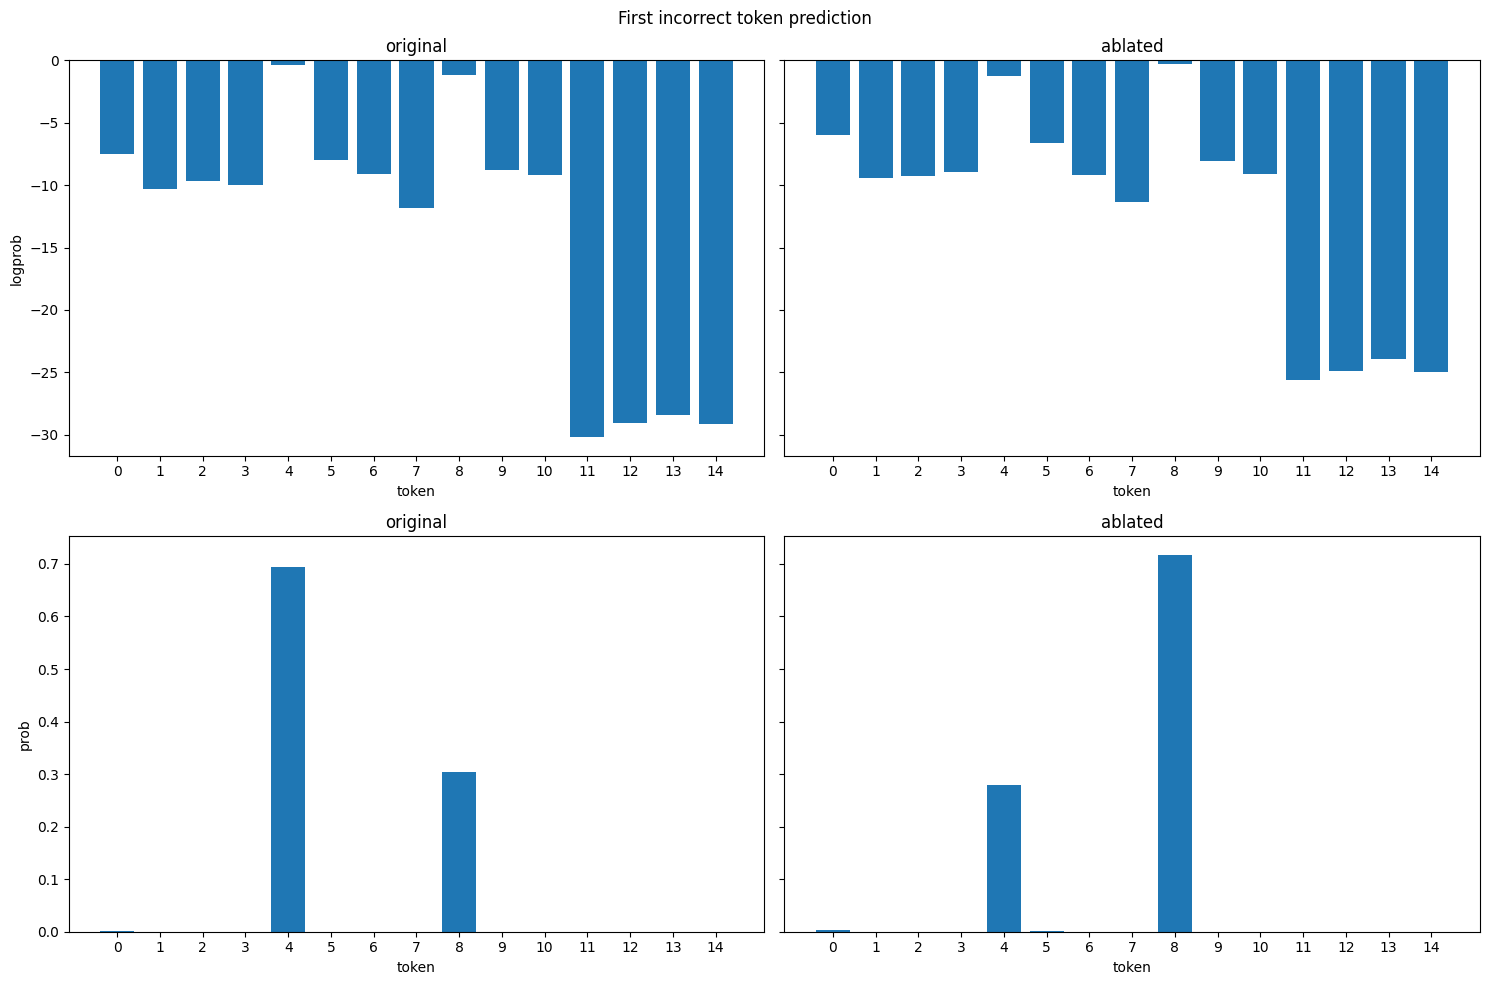

In [172]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10), sharey='row')

fig.suptitle("First incorrect token prediction")

# Log probabilities (top row)
ax1.bar(np.arange(15), F.log_softmax(logits_orig[-1]).detach().cpu().numpy())
ax2.bar(np.arange(15), F.log_softmax(logits_abl[-1]).detach().cpu().numpy())
ax1.set_title("original")
ax2.set_title("ablated")
ax1.set_ylabel("logprob")

# Probabilities (bottom row)
ax3.bar(np.arange(15), F.softmax(logits_orig[-1]).detach().cpu().numpy())
ax4.bar(np.arange(15), F.softmax(logits_abl[-1]).detach().cpu().numpy())
ax3.set_title("original")
ax4.set_title("ablated")
ax3.set_ylabel("prob")

# Set x-axis labels and ticks
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel("token")
    ax.set_xticks(np.arange(15))

# Adjust layout and display
plt.tight_layout()
plt.show()

## Finding the cause

In [77]:
@t.no_grad()
def quiz_diff_mask(quizzes):
    final_grid_slice = slice(-99, None)
    second_final_grid_slice = slice(-200, -101)

    idxs = t.argwhere(
        quizzes[:, final_grid_slice] != quizzes[:, second_final_grid_slice]
    )
    B, T = quizzes.shape
    start_idx = T + final_grid_slice.start
    idxs[:, 1] += start_idx
    return idxs

def get_mask(batch, mask):
    return batch[mask[:, 0], mask[:, 1]]


def reconstr_hook(activation, hook, sae_out):
    _, T, _ = activation.shape
    return sae_out[:, :T, :]

model.reset_hooks()

with t.inference_mode():
    _, cache = model.run_with_cache(batch[wrong_because_ablate, :-1])
    h = cache[sae.cfg.hook_name].clone()
    del cache
    feature_acts = sae.encode(h)
    del h
    sae_out = sae.decode(feature_acts)


tasks_correct = []
model.add_hook(sae.cfg.hook_name, partial(reconstr_hook, sae_out=sae_out))  # type: ignore
correct, _ = generate(
    model, batch[wrong_because_ablate], temperature=0.0, verbose=False
)
model.reset_hooks()
print("All tasks correct:", t.all(correct).item())

All tasks correct: True


In [76]:
tfm_cells = set(tuple(x) for x in quiz_diff_mask(batch[wrong_because_ablate]).tolist())

In [15]:
with t.inference_mode():
    sv_logits, cache = model.run_with_cache(batch[wrong_because_ablate[1]])
    sv_feature_acts = sae.encode(cache[sae.cfg.hook_name])
    sae_out = sae.decode(sv_feature_acts)

## Interpreting `gpt-0/blocks_8_mlp_out` SAE

### Finding the sparsity

In [11]:
feature_acts = []

n = 64 # 384
bs = 32

with t.no_grad():
    for i in range(0, n // bs, bs):
        batch_tokens = dataset_full[i : i + 32]["input_ids"].to(device)
        _, cache = model.run_with_cache(batch_tokens, names_filter=[sae.cfg.hook_name])
        acts = sae.encode(cache[sae.cfg.hook_name])
        feature_acts.append(acts[:, final_grid_slice])
        del cache

# ignore the bos token, get the number of features that activated in each token, averaged accross batch and position
feature_acts = t.cat(feature_acts, dim=0)[:, 1:]

l0 = (feature_acts > 0).float().sum(-1).detach()
print("average l0", l0.mean().item())
px.histogram(l0.flatten().cpu().numpy()).show()

average l0 64.07418060302734


In [10]:
feature_acts_contact = []

n = 64 # 384
bs = 32

with t.no_grad():
    for i in range(0, n // bs, bs):
        batch_tokens = dataset["contact"][i : i + 32]["input_ids"].to(device)
        _, cache = model.run_with_cache(batch_tokens, names_filter=[sae.cfg.hook_name])
        acts = sae.encode(cache[sae.cfg.hook_name])
        feature_acts_contact.append(acts[:, final_grid_slice])
        del cache

# ignore the bos token, get the number of features that activated in each token, averaged accross batch and position
feature_acts_contact = t.cat(feature_acts_contact, dim=0)[:, 1:]

l0 = (feature_acts_contact > 0).float().sum(-1).detach()
print("average l0", l0.mean().item())
px.histogram(l0.flatten().cpu().numpy()).show()

average l0 66.12815856933594


In [7]:
from sae_lens.analysis.feature_statistics import (
    get_W_U_W_dec_stats_df,
)

W_dec = sae.W_dec.detach().cpu()

# calculate the statistics of the logit weight distributions
W_U_stats_df_dec, dec_projection_onto_W_U = get_W_U_W_dec_stats_df(
    W_dec, model, cosine_sim=False
)
display(W_U_stats_df_dec)

,feature,mean,std,skewness,kurtosis
0,0,-0.008411,0.045923,-0.333212,2.507046
1,1,-0.000265,0.000574,-0.027515,2.221524
2,2,0.000290,0.008415,0.643761,1.989931
3,3,0.003134,0.063906,1.321536,4.109923
4,4,0.005751,0.010995,-0.162024,1.508211
...,...,...,...,...,...
16379,16379,0.040740,0.117200,0.925136,2.097044
16380,16380,0.011986,0.103558,0.865758,2.042682
16381,16381,-0.005119,0.022454,-0.541232,1.837249
16382,16382,-0.034678,0.093033,-0.978822,2.134010


DatasetDict({
    contact: Dataset({
        features: ['input_ids', 'label'],
        num_rows: 125000
    })
    corners: Dataset({
        features: ['input_ids', 'label'],
        num_rows: 125000
    })
    culture: Dataset({
        features: ['input_ids', 'label'],
        num_rows: 140
    })
    detect: Dataset({
        features: ['input_ids', 'label'],
        num_rows: 125000
    })
    frame: Dataset({
        features: ['input_ids', 'label'],
        num_rows: 125000
    })
    grow: Dataset({
        features: ['input_ids', 'label'],
        num_rows: 125000
    })
    half_fill: Dataset({
        features: ['input_ids', 'label'],
        num_rows: 125000
    })
    replace_color: Dataset({
        features: ['input_ids', 'label'],
        num_rows: 125000
    })
    translate: Dataset({
        features: ['input_ids', 'label'],
        num_rows: 125000
    })
})

### W_dec

Now let's investigate which W_dec neurons fire

## TODO

- Let's take a look at the loss w.r.t normal, zero and reconstruction for the all tasks and the contact task specifically.

- Like before, I'm going to look at the loss at only the final grid where the square is different to the square from the previous grid -- the "transform" squares

- Investiage which W_dec neurons fire

- Find the mlp in the other models that cause this same behaviour -- is this univeral neurons?